In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 69kB/s 
     |████████████████████████████████| 501kB 51.1MB/s 
     |████████████████████████████████| 3.1MB 41.7MB/s 


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import functools
import IPython.display as display

In [71]:
content_path = '/content/animal-celebes-crested-macaque-funny-50582 (1).jpg'
style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


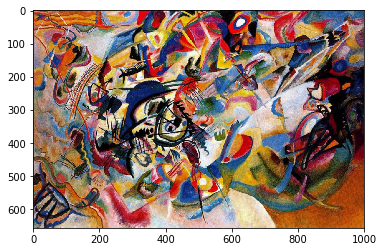

In [72]:
img = plt.imread(style_path)
plt.imshow(img)

In [0]:
def load_img(image_path):
  max_dim = 1024
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img , channels = 3)
  img = tf.image.convert_image_dtype(img , tf.float32)
  
  shape = tf.cast(tf.shape(img)[:-1] , tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  
  new_shape = tf.cast(shape * scale , tf.int32)
  
  img = tf.image.resize(img , new_shape)
  img = img[tf.newaxis, :]
  
  return img

In [0]:
def imshow(image , title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image)
    
  plt.imshow(image)
  if title:
    plt.title(title)

In [0]:
content_image = load_img(content_path)

In [0]:
style_image = load_img(style_path)

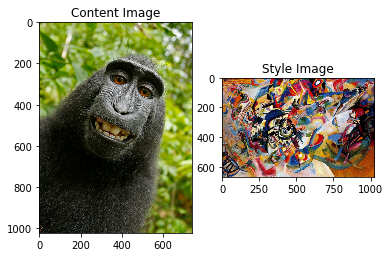

In [77]:
plt.subplot(1 , 2 , 1)
imshow(content_image , title = 'Content Image')

plt.subplot(1 , 2 , 2)
imshow(style_image , title = 'Style Image')

In [78]:
prc_img = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
prc_img = tf.image.resize(prc_img , (224 , 224))
vgg = tf.keras.applications.VGG19(weights='imagenet' , include_top = True)
predictions = vgg(prc_img)
predictions.shape

TensorShape([1, 1000])

In [79]:
predicted = tf.keras.applications.vgg19.decode_predictions(predictions.numpy())[0]
[(class_name , prob) for (number , class_name , prob) in predicted]

[('siamang', 0.195111),
 ('gibbon', 0.18607202),
 ('guenon', 0.17519185),
 ('indri', 0.17238662),
 ('macaque', 0.102000296)]

In [80]:
vgg = tf.keras.applications.VGG19(weights='imagenet' , include_top = False)
print()
for layer in vgg.layers:
  print(layer.name)


input_11
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
content_extraction_layers = ['block5_conv2']

style_extraction_layers = ['block1_conv1',
                           'block2_conv1',
                           'block3_conv1',
                           'block4_conv1',
                           'block5_conv1']

num_content_layers = len(content_extraction_layers)
num_style_layers = len(style_extraction_layers)

In [0]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(weights = 'imagenet' , include_top = False)
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  
  return tf.keras.Model(inputs = [vgg.input] , outputs = outputs)

In [83]:
style_extractor = vgg_layers(style_extraction_layers)
style_vector = style_extractor(style_image * 255)

for name , output in zip(style_extraction_layers , style_vector):
  print(name)
  print('Shape : {}'.format(output.numpy().shape))
  print('Min : {}'.format(output.numpy().min()))
  print('Max : {}'.format(output.numpy().max()))
  print('Mean : {}'.format(output.numpy().mean()))
  print()

block1_conv1
Shape : (1, 672, 1024, 64)
Min : 0.0
Max : 839.8341674804688
Mean : 30.934349060058594

block2_conv1
Shape : (1, 336, 512, 128)
Min : 0.0
Max : 4161.05419921875
Mean : 166.1641387939453

block3_conv1
Shape : (1, 168, 256, 256)
Min : 0.0
Max : 8546.0859375
Mean : 176.71337890625

block4_conv1
Shape : (1, 84, 128, 512)
Min : 0.0
Max : 22654.9765625
Mean : 640.0374755859375

block5_conv1
Shape : (1, 42, 64, 512)
Min : 0.0
Max : 3908.3828125
Mean : 48.875732421875



In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd' , input_tensor , input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2] , tf.float32)
  return result/(num_locations)

In [0]:
class Model(tf.keras.models.Model):
  def __init__(self , style_extraction_layers , content_extraction_layers):
    super(Model , self).__init__()
    self.vgg = vgg_layers(style_extraction_layers + content_extraction_layers)
    self.style_extraction_layers = style_extraction_layers
    self.content_extraction_layers = content_extraction_layers
    self.num_style_layers = len(style_extraction_layers)
    self.vgg.trainable = False
    
  def call(self , inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs , content_outputs = (outputs[:self.num_style_layers] , outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style) for style in style_outputs]
    
    content_dict = {content_name : value for content_name , value in zip(self.content_extraction_layers , content_outputs)}
    
    style_dict = {style_name : value for style_name , value in zip(self.style_extraction_layers , style_outputs)}
    
    return {'content' : content_dict , 'style' : style_dict}

In [86]:
extractor = Model(style_extraction_layers , content_extraction_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles: ')
for name , output in sorted(results['style'].items()):
  print(' {}'.format(name))
  print(' shape: {}'.format(output.numpy().shape))
  print(' min: {}'.format(output.numpy().min()))
  print(' max: {}'.format(output.numpy().max()))
  print(' mean: {}'.format(output.numpy().mean()))
  print()
  
print('Content: ')
for name , output in sorted(results['content'].items()):
  print(' {}'.format(name))
  print(' shape: {}'.format(output.numpy().shape))
  print(' min: {}'.format(output.numpy().min()))
  print(' max: {}'.format(output.numpy().max()))
  print(' mean: {}'.format(output.numpy().mean()))

Styles: 
 block1_conv1
 shape: (1, 64, 64)
 min: 0.027910616248846054
 max: 28083.232421875
 mean: 442.88067626953125

 block2_conv1
 shape: (1, 128, 128)
 min: 0.0
 max: 59371.546875
 mean: 11217.92578125

 block3_conv1
 shape: (1, 256, 256)
 min: 0.0
 max: 445721.34375
 mean: 9743.2041015625

 block4_conv1
 shape: (1, 512, 512)
 min: 4.953263759613037
 max: 4539068.0
 mean: 154656.171875

 block5_conv1
 shape: (1, 512, 512)
 min: 0.0
 max: 58215.91796875
 mean: 942.3705444335938

Content: 
 block5_conv2
 shape: (1, 64, 46, 512)
 min: 0.0
 max: 1391.859619140625
 mean: 10.895912170410156


In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
image = tf.Variable(content_image)

In [0]:
def clip_image(image):
  return tf.clip_by_value(image , clip_value_min = 0.0 , clip_value_max = 1.0)

In [0]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02 , beta_1 = 0.99 , epsilon = 1e-1)

In [0]:
style_weight = 1e-2
content_weight = 1e4

In [0]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
  
  style_loss *= style_weight / num_style_layers
  
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
  
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  
  return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    
  gradient = tape.gradient(loss , image)
  optimizer.apply_gradients([(gradient , image)])
  image.assign(clip_image(image))

In [94]:
image.shape

TensorShape([1, 1024, 740, 3])

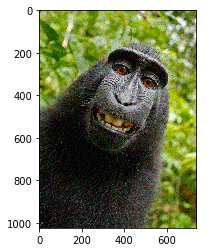

In [95]:
train_step(image)
train_step(image)
train_step(image)

plt.imshow(image.read_value()[0])

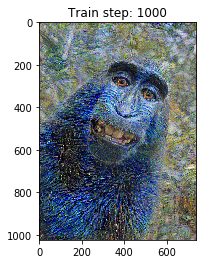

Total time: 282.0


In [60]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
def high_pass_x_y(image):
  x_var = image[: , : , 1: , :] - image[: , : , :-1 , :]
  y_var = image[: , 1: , : , :] - image[: , :-1 , : , :]
  
  return x_var , y_var

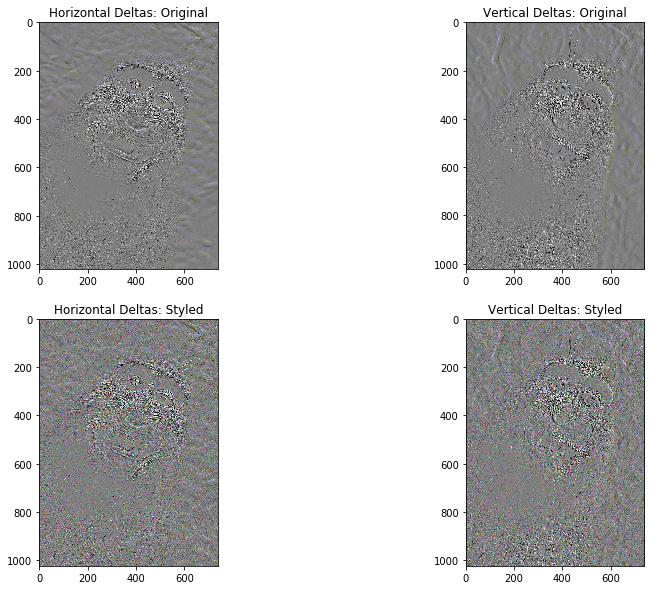

In [97]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_image(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_image(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_image(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_image(2*x_deltas+0.5), "Vertical Deltas: Styled")

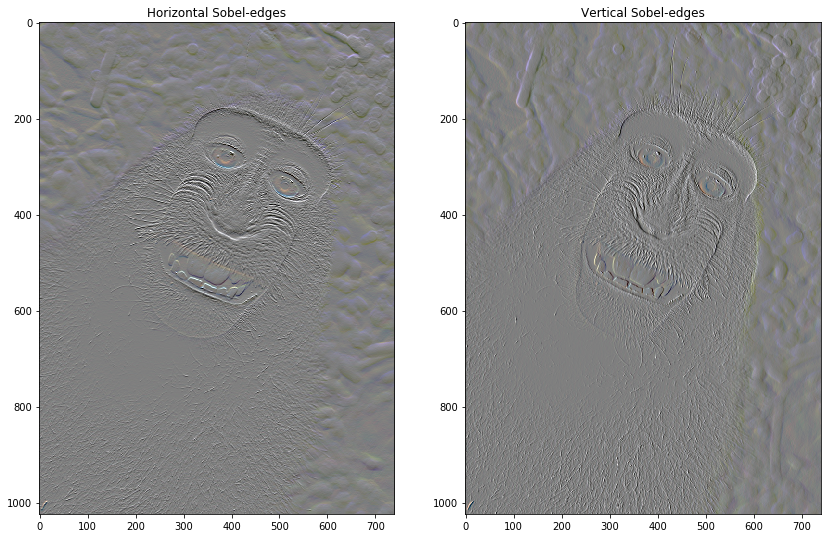

In [98]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_image(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_image(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [0]:
def total_variation_loss(image):
  x_deltas , y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [0]:
total_variation_weight=1e8

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * total_variation_loss(image)

  gradient = tape.gradient(loss, image)
  optimizer.apply_gradients([(gradient, image)])
  image.assign(clip_image(image))

In [0]:
image = tf.Variable(content_image)

In [0]:
import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

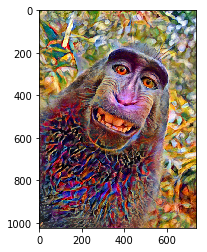

In [104]:
imshow(image.read_value())